In [19]:
# pip list --format=freeze > requirements.txt
# pip install -r requirements.txt

In [420]:
%matplotlib inline

In [421]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import pipeline
from datetime import datetime

# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [460]:
path = "/Users/emilygong/Desktop/RUW-Oil-Prediction/data"
os.chdir(path)

# Read in the Dataset

In [461]:
final = pd.read_csv('final.csv')
final['date'] = pd.to_datetime(final['date'])

# Aggregate News Emotion by Day

In [462]:
df_by_day = final.set_index("date").groupby(pd.Grouper(freq='D')).mean().reset_index()

/var/folders/9f/07hlwdb51gggdsry0cqd7rdw0000gn/T/ipykernel_8928/3311095233.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_by_day = final.set_index("date").groupby(pd.Grouper(freq='D')).mean().reset_index()


In [463]:
df_by_day = df_by_day.dropna().reset_index(drop=True)
df_by_day = df_by_day[df_by_day['date'] >= datetime(2022, 2,1)]
df_by_day = df_by_day[['date', 'anger', 'fear', 'joy', 'sadness', 'love', 'surprise']]

In [464]:
price = pd.merge(df_by_day, oil_price, on = 'date')
price_full = pd.merge(df_by_day, oil_price_test, on = 'date', how = "right")
price.to_csv("price.csv", index = False)
price_full.to_csv("price_full.csv", index = False)

# Simple Plots

# Interpolate for missing values

Oil prices are only available during the week, but for better results, we choose to interpolate 

In [475]:
price_full

,date,anger,fear,joy,sadness,love,surprise,price
0,2022-11-21,NaN,NaN,NaN,NaN,NaN,NaN,79.74
1,2022-11-18,NaN,NaN,NaN,NaN,NaN,NaN,80.07
2,2022-11-17,NaN,NaN,NaN,NaN,NaN,NaN,81.69
3,2022-11-16,NaN,NaN,NaN,NaN,NaN,NaN,85.62
4,2022-11-15,NaN,NaN,NaN,NaN,NaN,NaN,86.87
...,...,...,...,...,...,...,...,...
199,2022-02-07,0.795322,0.129422,0.049899,0.017454,0.005051,0.002852,91.25
200,2022-02-04,0.773544,0.170671,0.030413,0.019233,0.003442,0.002697,92.27
201,2022-02-03,0.768936,0.152720,0.057484,0.014726,0.004226,0.001908,90.17
202,2022-02-02,0.834859,0.083082,0.047508,0.027382,0.004524,0.002645,88.16


In [476]:
price_full = price_full.sort_values('date').reset_index(drop=True)
price_full.index = price_full['date']
price_full = price_full[['price']]

In [477]:
na = np.arange(np.datetime64("2022-02-01"), np.datetime64("2022-11-22"))
df = pd.DataFrame({'date': na})
df.index = df['date']
df = df.join(price_full, how = 'left')
df = df[['price']]
price_full = df.interpolate()
price_full

,price
date,
2022-02-01,88.22
2022-02-02,88.16
2022-02-03,90.17
2022-02-04,92.27
2022-02-05,91.93
...,...
2022-11-17,81.69
2022-11-18,80.07
2022-11-19,79.96


# Fit auto ARIMA & Predict

In [478]:
price_full_diff = price_full.diff().dropna()
price_full_diff_2 = price_full.diff().diff().dropna()

In [479]:
model = pm.auto_arima(price_full, seasonal=False,
                      start_p=0, start_q=0, m=1, max_order=2, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)
model_diff = pm.auto_arima(price_full_diff, seasonal=False,
                      start_p=0, start_q=0, m=1, max_order=2, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)
model_diff_2 = pm.auto_arima(price_full_diff_2, seasonal=False,
                      start_p=0, start_q=0, m=1, max_order=2, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1371.776, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1373.236, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1373.238, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1369.816, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1375.225, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.187 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1369.816, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1371.272, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1371.274, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1373.260, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1371.776, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.123 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1555.667, Time=

# Interpret the Model

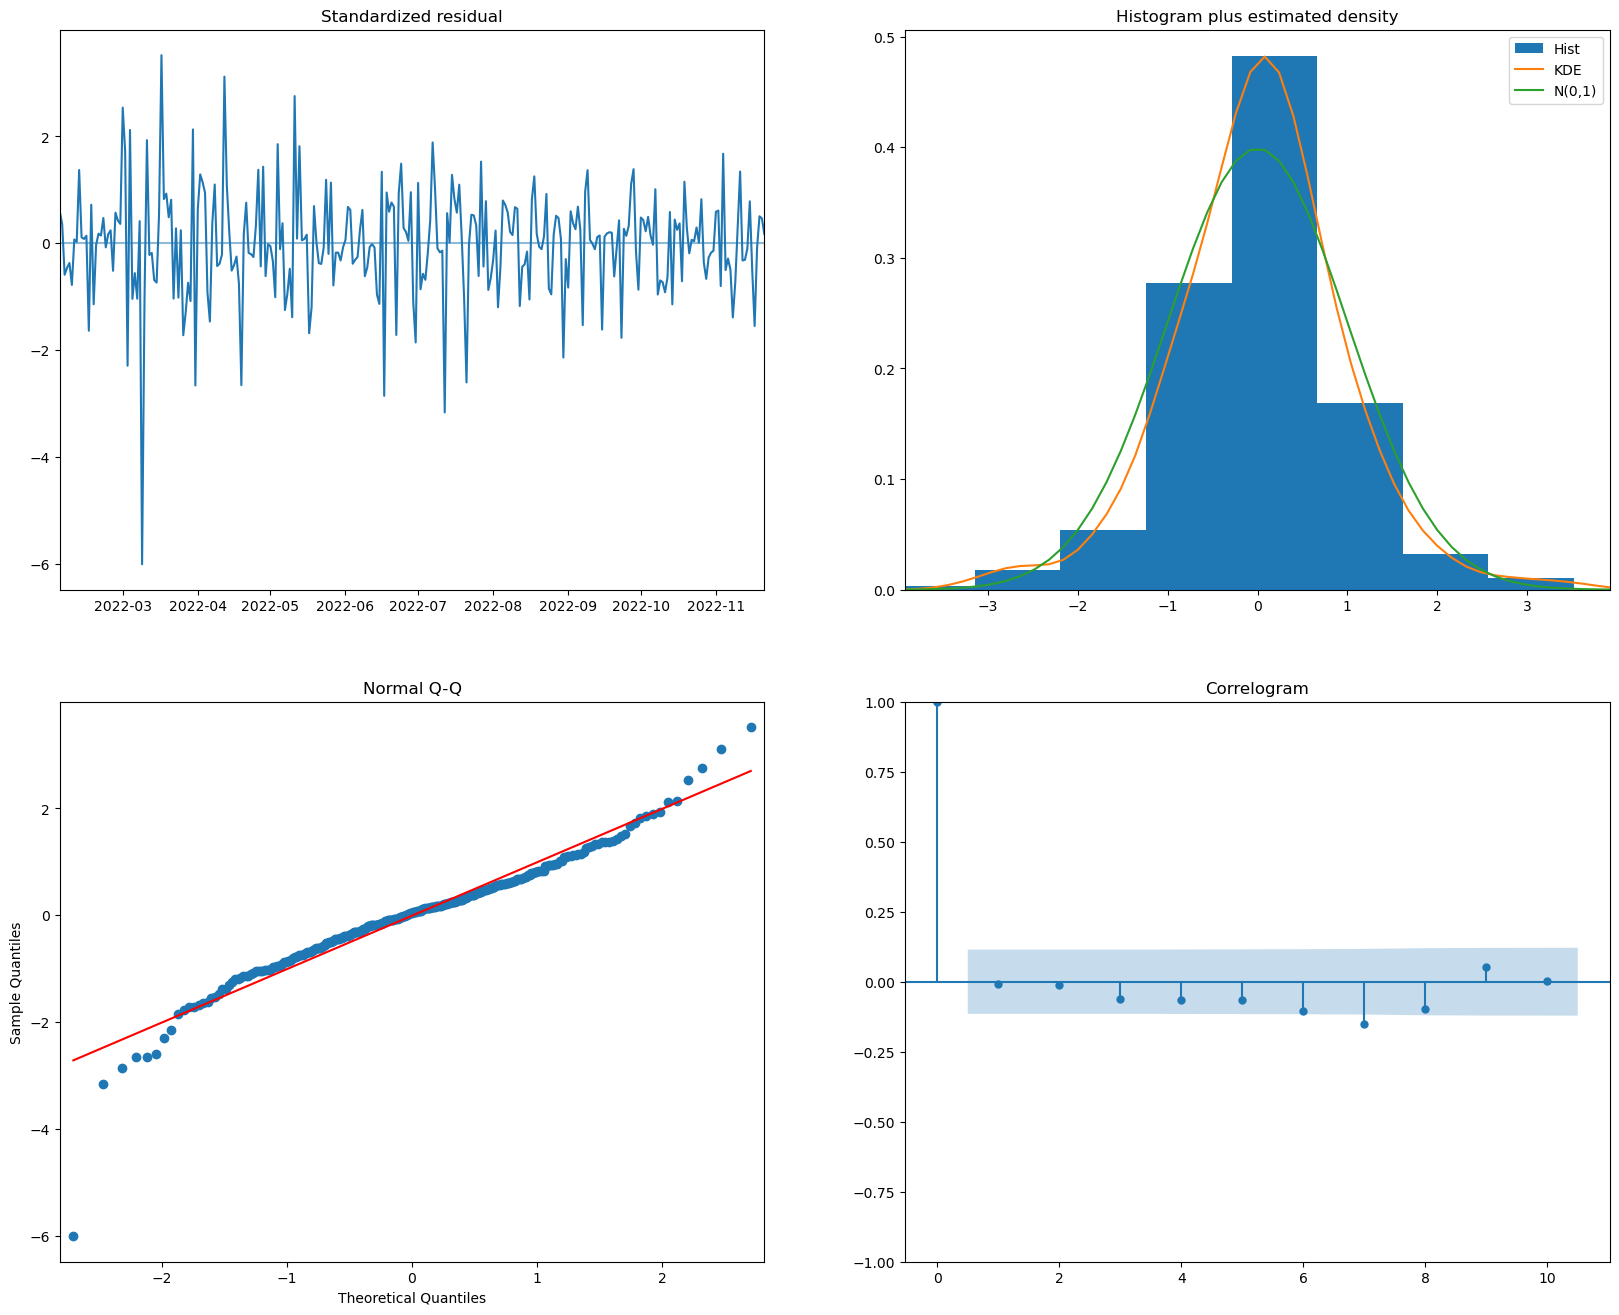

In [480]:
model_diff_2.plot_diagnostics(figsize=(20,16))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance EXCEPT between March and April.

Top Right: The density plot suggest the distribution roughly has a mean zero, but has data much more concentrated towards the mean compared to a normal distribution.

Bottom left: The dots fall roughly in line with the red line, so there's no strong skewness.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

**HONESTLY, NOT QUITE SURE IF THIS IS A GOOD MODEL**

# Predict the Results

In [481]:
import pmdarima as pm

train = price_full[:253]
test = price_full[253:]

train_diff = price_full_diff[:253]
test_diff = price_full_diff[253:]

train_diff_2 = price_full_diff_2[:253]
test_diff_2 = price_full_diff_2[253:]

model.fit(train)
model_diff.fit(train_diff)
model_diff_2.fit(train_diff_2)

forecast=model.predict(n_periods=39, return_conf_int=True)
forecast_diff=model_diff.predict(n_periods=39, return_conf_int=True)
forecast_diff_2=model_diff_2.predict(n_periods=39,return_conf_int=True)

forecast_df = forecast_diff_2[0].to_frame()
forecast_df.index = test_diff_2.index
forecast_df.rename(columns={0:'prediction'}, inplace=True)

In [482]:
predictions = test_diff_2.join(forecast_df)

nones = [None]*len(train_diff_2)
s = pd.Series(nones, name="predictions")
s.to_frame()

train_diff_2.join(s)

predit_df= pd.concat([train_diff_2, predictions])

Text(0.5, 1.0, 'Prediction (Orange) vs. Reality (Blue)')

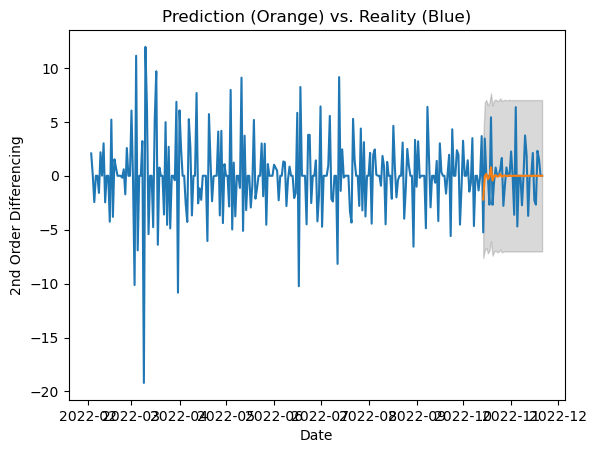

In [483]:
# Forecast
n_periods = 39
fc, confint = model_diff_2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test_diff_2.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(predit_df)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.xlabel("Date")
plt.ylabel("2nd Order Differencing")
plt.title("Prediction (Orange) vs. Reality (Blue)")

As we can see, it's not a very good prediction...

# Fit VARMAX

Now, let's try utilizing the sentiment analysis and text classification variables and see if they can help us with this task.

In [ ]:
import statsmodels.api as sm
exog = price['price']
mod = sm.tsa.VARMAX(price[['anger', 'fear', 'joy', 'sadness', 'love', 'surprise']], order=(5,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
res.summary()

/Users/emilygong/opt/anaconda3/envs/torch/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [69]:
endog

,dln_inv,dln_inc,dln_consump
qtr,,,
1960-04-01,-0.005571,0.030570,0.014355
1960-07-01,0.032970,0.042111,0.030411
1960-10-01,0.037139,0.016360,0.031749
1961-01-01,0.094363,0.031939,0.024257
1961-04-01,-0.043591,0.021381,-0.002181
...,...,...,...
1977-10-01,0.026188,0.021032,0.017272
1978-01-01,0.025520,0.010843,0.012479
1978-04-01,0.035580,0.014599,0.018431


In [64]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/')
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc['1960-04-01':'1978-10-01', ['dln_inv', 'dln_inc', 'dln_consump']]

In [66]:
exog = endog['dln_consump']
mod = sm.tsa.VARMAX(endog[['dln_inv', 'dln_inc']], order=(2,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                            VARX(2)   Log Likelihood                 361.039
Date:                    Fri, 25 Nov 2022   AIC                           -696.078
Time:                            23:15:54   BIC                           -665.951
Sample:                        04-01-1960   HQIC                          -684.049
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            0.05, 10.10   Jarque-Bera (JB):          11.21, 2.46
Prob(Q):                        0.83, 0.00   Prob(JB):                   0.00, 0.29
Heteroskedasticity (H):         0.45, 0.40   Skew:                      0.16, -0.38
Prob(H) (two-sided):            0.05, 0.03   Kurtosis:                   4.87, 3.45


# Reference

* https://www.justintodata.com/arima-models-in-python-time-series-prediction/
* https://www.section.io/engineering-education/multivariate-time-series-using-auto-arima/
* https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python
* https://people.duke.edu/~rnau/411arim2.htm